# Trabalho Final de Estágio Docente
## Estagiário: Douglas Macedo Sgrott
## Aluno: Paulo Roberto Albuquerque
## Data de entrega: 23/06/2021 (quarta-feira)
## O trabalho está organizado em partes:
 - ### **Dataset: Onde você irá limpar e pre processar o dataset. Atribua a versão final do dataset em um dataframe chamado df.**
 - Separação dos dados: Aqui os dados são normalizados e divididos em Treino/Validação. Não precisa modificar o código.
 - ### **Arquitetura da Rede Neural: Onde você vai definir a arquitetura da rede neural.**
 - ### **Parâmetros de otimização da Rede Neural: Onde você vai definir outros parâmetros da rede neural.**
 - Visualização dos resultados: Onde os resultados são obtidos
 - Exemplos: Servir como exemplo de análise, data cleaning e pré-processamento.


In [1386]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# importing stuff
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# a lot of stuff
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

# Z-score / outliers stuff
from scipy import stats

# Rede Neural stuff
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import plot_model

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aula-2-ia-dataset/CasasParaAlugar.xlsx
/kaggle/input/aula-2-ia-dataset/CasasParaAlugar.csv


# Dataset

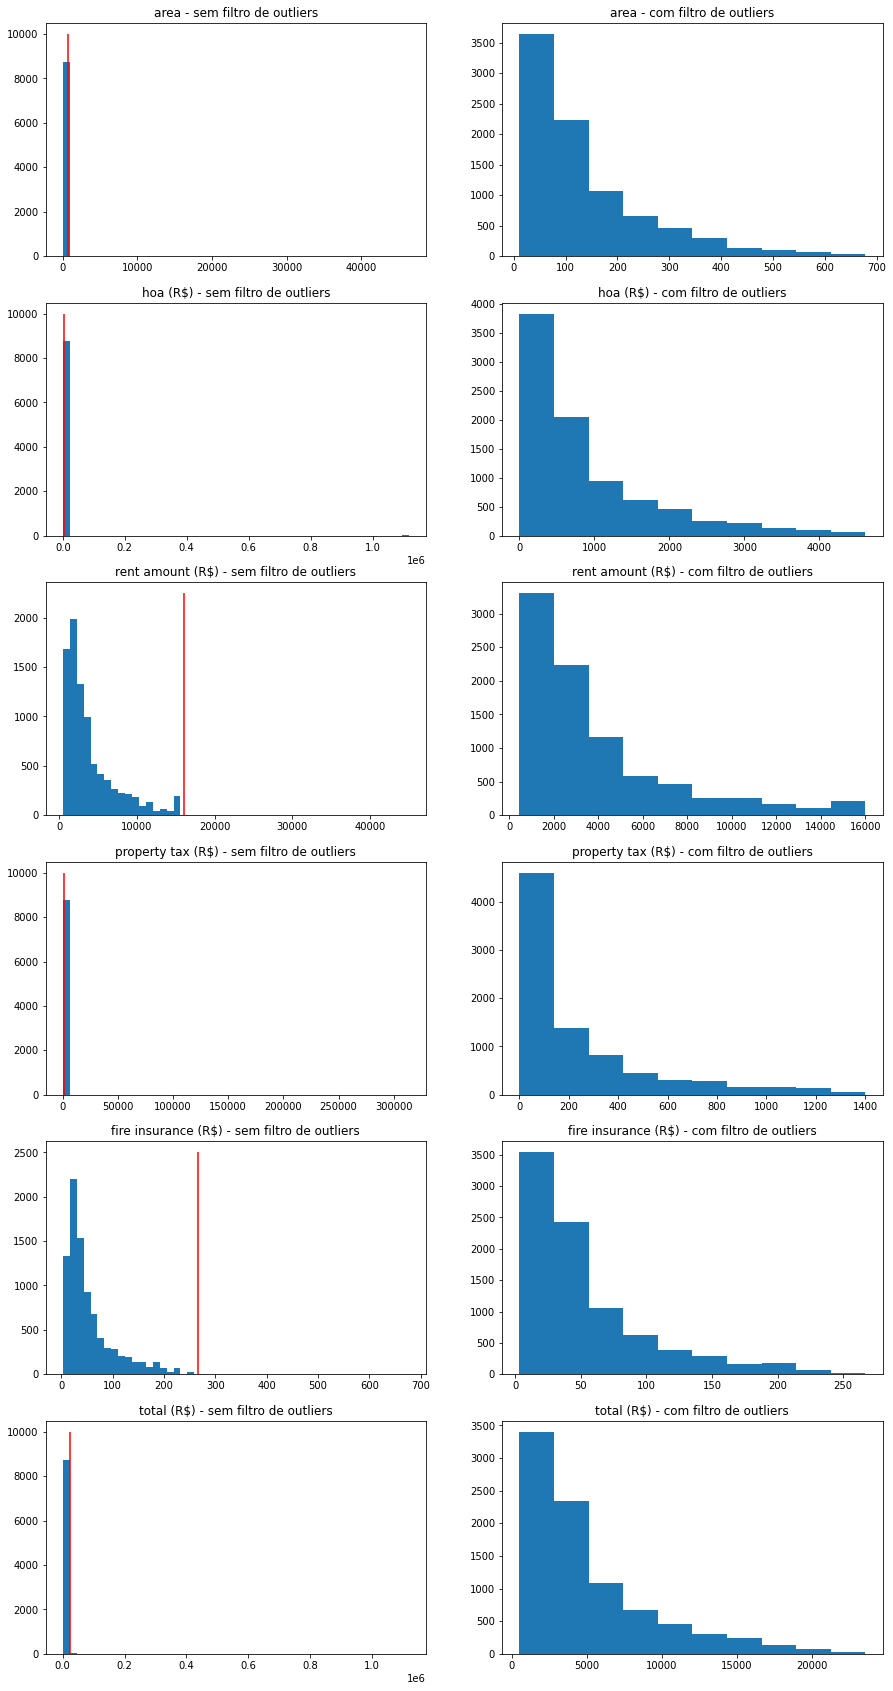

In [1387]:
df = pd.read_csv('../input/aula-2-ia-dataset/CasasParaAlugar.csv', index_col=0)

## Colunas Vazias Parte 1 (Antes da remoção dos Outliers):
#   Rooms para 1
df['rooms'].fillna(value=1, inplace=True)
#   Bathroom para 1
df['bathroom'].fillna(value=1, inplace=True)
#   Parking Spaces para 0
df['parking spaces'].fillna(value=0, inplace=True)
#   Floor para 0
df['floor'].fillna(value=0, inplace=True)
#   Animal para "acept" discreto = 1
df['animal'].fillna(value=1, inplace=True)
#   Furniture para "not furnished" discreto = 0
df['furniture'].fillna(value=0, inplace=True)
#   City para a moda
df['city'].fillna(value=df['city'].mode(), inplace=True)

## Substituição:
#   Floor subst "-" para 0 e depois string para int
df['floor'].replace(to_replace='-', value=0, inplace=True)
df['floor'] = pd.to_numeric(df['floor'])
#   Animal subst strings para valor discreto
df['animal'].replace(to_replace='acept', value=1, inplace=True)
df['animal'].replace(to_replace='not acept', value=0, inplace=True)
#   Furniture subst strings para valor discreto
df['furniture'].replace(to_replace='furnished', value=1, inplace=True)
df['furniture'].replace(to_replace='not furnished', value=0, inplace=True)
#   City para valores discretos
df.loc[df['city'] == 'Belo Horizonte', 'city'] = 1
df.loc[df['city'] == 'São Paulo', 'city'] = 2
df.loc[df['city'] == 'Porto Alegre', 'city'] = 3
df.loc[df['city'] == 'Rio de Janeiro', 'city'] = 4
df.loc[df['city'] == 'Campinas', 'city'] = 5
df.dropna(subset=['city'], inplace=True)
df['city'] = pd.to_numeric(df['city'])

## Ouliers:
#   Floor removemos andares maiores que 60
df.drop(df.loc[df['floor'] > 60].index, inplace=True)
#   Removemos outliers das outras features usando os respectivos valores para Z
columns = ['area', 'hoa (R$)', 'rent amount (R$)', 'property tax (R$)', 'fire insurance (R$)', 'total (R$)']
zs =      [1.0   , 0.2       , 4                 , 0.3                , 5                    , 1           ]

fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(15,30))
for i, col in enumerate(columns):
    axes[i][0].hist(df[col], bins=50)
    
    mask = np.abs(stats.zscore(df[col].dropna())) < zs[i] # Usando cada z para cada coluna
    dado_filtrado = df[col].dropna()[mask]
    df[col] = df[col].dropna()[mask] # Aplicamos na df a remoção
    
    axes[i][1].hist(dado_filtrado)
    ymax = axes[i][0].get_yticks()[-1]
    axes[i][0].vlines(x=max(dado_filtrado), ymin=0, ymax=ymax, color="red")
    axes[i][0].set_title("{} - sem filtro de outliers".format(col))
    axes[i][1].set_title("{} - com filtro de outliers".format(col))

In [1388]:
## Colunas Vazias Parte 2:
#   Se ambos Hoa e Rent estiverem faltando, apaga a linha
df.dropna(subset=['hoa (R$)', 'rent amount (R$)'], how='all', inplace=True)
#   Hoa = proporção média (hoa/rent) multiplicado pelo rent daquela linha
mean_hoa_rent = df['hoa (R$)'].mean() / df['rent amount (R$)'].mean()
df['hoa (R$)'] = df.apply(
    lambda row: row['rent amount (R$)'] * mean_hoa_rent if np.isnan(row['hoa (R$)']) else row['hoa (R$)'],
    axis=1
)
#   Rent = proporção média (hoa/rent) dividido pelo hoa daquela linha
df['rent amount (R$)'] = df.apply(
    lambda row: row['hoa (R$)'] / mean_hoa_rent if np.isnan(row['rent amount (R$)']) else row['rent amount (R$)'],
    axis=1
)
#   Tax para média
df['property tax (R$)'].fillna(value=df['property tax (R$)'].mean(), inplace=True)
#   Insurance média
df['fire insurance (R$)'].fillna(value=df['fire insurance (R$)'].mean(), inplace=True)
#   Total soma dos outros valores
df['total (R$)'] = df.apply(
    lambda row: row['hoa (R$)'] + row['rent amount (R$)'] + row['property tax (R$)'] + row['fire insurance (R$)'],
    axis=1
)
#   Area apaga linha
df.dropna(subset=['area'], inplace=True)


# df.drop(columns='area', inplace=True)
# df.drop(columns='parking spaces', inplace=True)
# df.drop(columns='bathroom', inplace=True)
# df.drop(columns='rooms', inplace=True)
# df.drop(columns='floor', inplace=True)
# df.drop(columns='animal', inplace=True)
# df.drop(columns='furniture', inplace=True)

df.describe()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,8581.000000,8581.000000,8581.000000,8581.000000,8581.000000,8581.000000,8581.000000,8581.000000,8581.000000,8581.000000,8581.000000,8581.000000,8581.000000
mean,2.513810,135.656217,2.353921,2.103834,1.427806,4.571262,0.798042,0.219904,859.410860,3851.244016,233.241014,52.487933,4996.383823
std,1.120253,114.809589,1.188530,1.357380,1.524337,5.264027,0.401484,0.414206,917.965432,3401.176964,269.864866,43.202067,4176.175264
min,1.000000,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,11.000000
25%,2.000000,57.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,220.000000,1510.000000,46.000000,22.000000,2056.556551
50%,2.000000,90.000000,2.000000,2.000000,1.000000,3.000000,1.000000,0.000000,560.000000,2640.000000,156.000000,40.000000,3528.556551
75%,3.000000,180.000000,3.000000,3.000000,2.000000,7.000000,1.000000,0.000000,1200.000000,4950.000000,269.000000,61.000000,6508.000000
max,5.000000,678.000000,13.000000,10.000000,10.000000,46.000000,1.000000,1.000000,4614.000000,21296.825344,1400.000000,267.000000,26207.381895


## Gráfico da distribuição dos valores

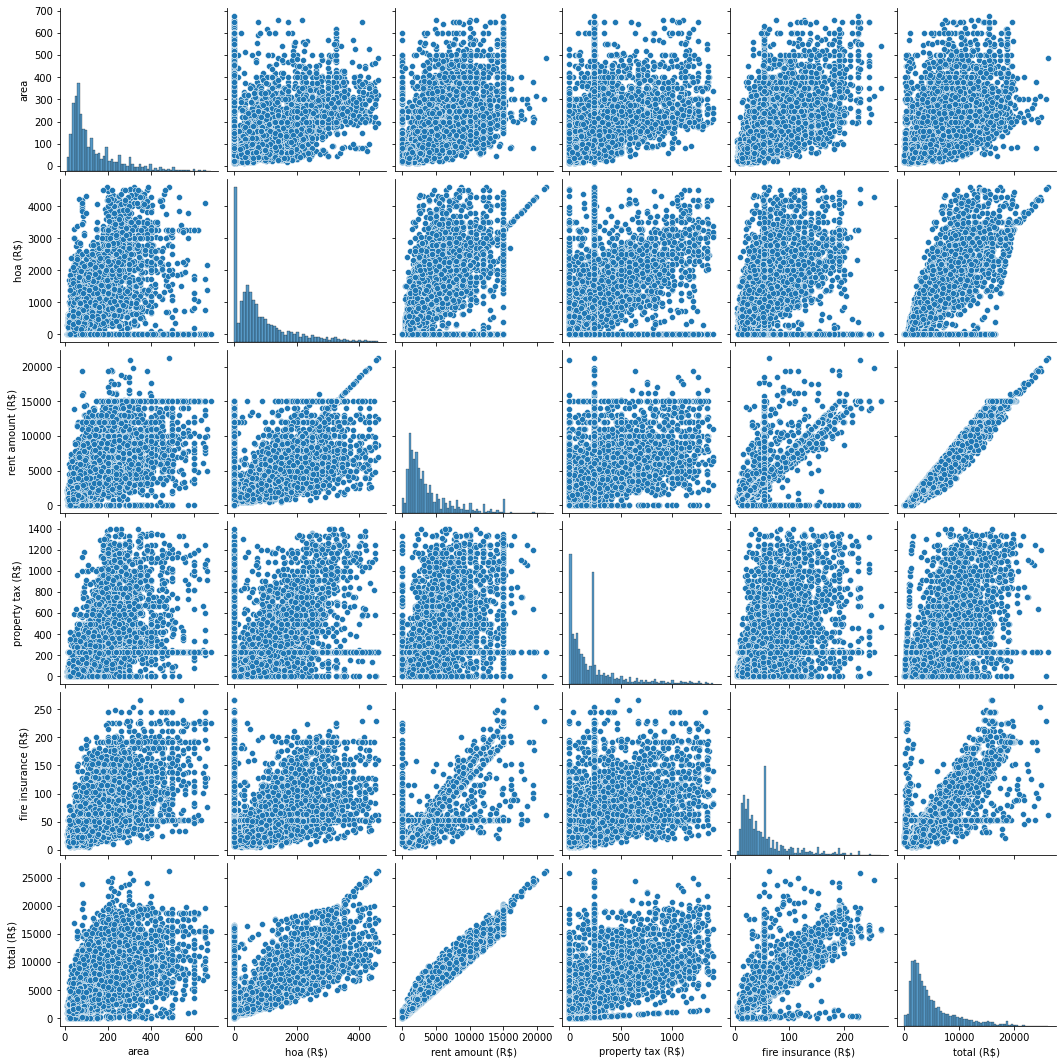

In [1389]:
sns.pairplot(df[['area', 'hoa (R$)', 'rent amount (R$)', 'property tax (R$)', 'fire insurance (R$)', 'total (R$)']])

# Separação dos dados

In [1390]:
# Normalizamos os dados de df em uma escala de [0, 1]
# Estou fazendo isto aqui pois temos que "desnormalizar" na hora de gerar os gráficos de R²
column_names = df.columns
scaler = MinMaxScaler()
scaler.fit(df)
df = scaler.transform(df)
df = pd.DataFrame(df)
df.columns = column_names

# Pegamos o dataset df e separamos em x (entrada) e y (saida), numa separação 70% treino e 30% validação
input_dim = df.shape[1] - 1
x = df.drop(columns='total (R$)')
y = df['total (R$)']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.30, random_state=42)

# Arquitetura da Rede Neural
#### Criei um código bem simples pra permitir criar diferentes redes neurais modificando apenas algumas variáveis (EM CAPSLOCK),
#### Mas se quiser criar sua própria arquitetura mais customizada, fique a vontade

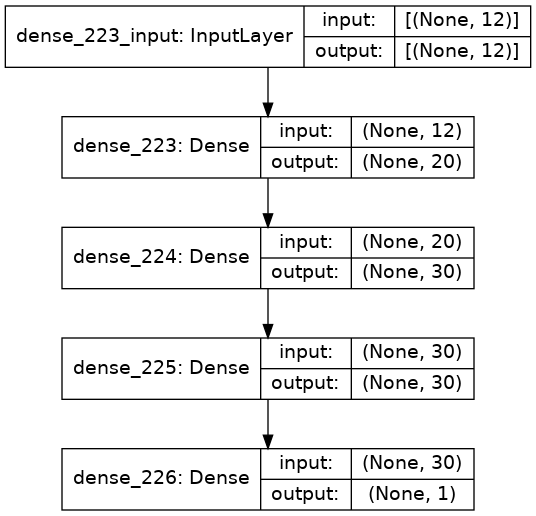

In [1391]:
NEURONIOS_CAMADA_INICIAL = 20

# Número de camadas intermediárias e neurônios. Tamanho do array são os números de camadas, elementos do array são números de neurônios.
# Ex: [30, 15] = 2 camadas intermediárias com 30 neurônios na primeira e 15 neurônios na segunda
# Ex: [] = Nenhuma camada intermediária
# Ex: [10, 10, 10, 10, 50] = 5 camadas intermediárias, com 10 neurônios nas 4 primeiras e 50 neurônios na última
NEURONIOS_CAMADAS_INTERMEDIARIAS = [30, 30]

# Usar dropout: True para usar, False para não usar
USAR_DROPOUT = False

# Porcentagem de Dropout: valor entre 0 e 1
DROPOUT_VALUE = 0.005

# Regularizador: None = Não usar regularizador, 'l1' = Reg L1, 'l2' = Reg L2
TIPO_REGULARIZADOR = 'l1'

# Função de ativação: 'relu', 'tanh', 'sigmoid', 'softmax', 'softplus', 'elu'
FN_ATIVACAO = 'relu'

# #####################################################################################
# Definição da ARQUITETURA da Rede Neural
model = Sequential()

# Primeira camada da RNA (input_dim entradas)
model.add(Dense(units=NEURONIOS_CAMADA_INICIAL, input_dim=input_dim, activation=FN_ATIVACAO, kernel_regularizer=TIPO_REGULARIZADOR))
# Camadas intermediárias
for UNITS in NEURONIOS_CAMADAS_INTERMEDIARIAS:
    model.add(Dense(units=UNITS, activation=FN_ATIVACAO, kernel_regularizer=TIPO_REGULARIZADOR))
    if USAR_DROPOUT:
        model.add(Dropout(DROPOUT_VALUE, input_shape=(120,)))
# Última camada da RNA (1 saída)
model.add(Dense(units=1, activation=FN_ATIVACAO))


# "Doug, mas que código tosco!" Também acho... Caso você queira criar sua própria arquitetura
# sem usar os parâmetros acima, é bem simples. Segue abaixo um exemplo meio doideira:
# model = Sequential()
# model.add(Dense(units=30, input_dim=input_dim, activation='relu', kernel_regularizer='l1'))
# model.add(Dropout(0.4, input_shape=(30,)))
# model.add(Dense(units=20, activation='tanh', kernel_regularizer='l2'))
# model.add(Dense(units=20, activation='relu', kernel_regularizer=None))
# model.add(Dense(units=1, activation='relu'))

plot_model(model, show_shapes=True)

# Parâmetros de otimização da Rede Neural
#### Pode alterar os valores das variáveis que estão EM CAPSLOCK

In [1392]:
CALLBACKS = [] # Definição dos callbacks a serem utilizados. Isso aqui é opcional, mas pode ajudar: https://keras.io/api/callbacks/early_stopping/
LOSS = 'mean_absolute_error' # 'mean_absolute_error', 'mean_squared_error'
BATCH_SIZE = 150
EPOCHS = 50
OPTIMIZER = 'adam' # 'adam' é o mais utilizado. Caso prefira outro, como 'sgd', boa sorte!

# Compilação do modelo + Definição da Função de Loss e do Otimizador
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=LOSS)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=CALLBACKS,
    validation_data=(x_valid, y_valid),
)

Epoch 1/50
41/41 [==============================] - 1s 8ms/step - loss: 2.9374 - mean_absolute_error: 0.0895 - val_loss: 2.4434 - val_mean_absolute_error: 0.0664
Epoch 2/50
41/41 [==============================] - 0s 3ms/step - loss: 2.2919 - mean_absolute_error: 0.0590 - val_loss: 1.8698 - val_mean_absolute_error: 0.0484
Epoch 3/50
41/41 [==============================] - 0s 3ms/step - loss: 1.7419 - mean_absolute_error: 0.0433 - val_loss: 1.3851 - val_mean_absolute_error: 0.0329
Epoch 4/50
41/41 [==============================] - 0s 3ms/step - loss: 1.2785 - mean_absolute_error: 0.0289 - val_loss: 0.9809 - val_mean_absolute_error: 0.0222
Epoch 5/50
41/41 [==============================] - 0s 3ms/step - loss: 0.8952 - mean_absolute_error: 0.0207 - val_loss: 0.6569 - val_mean_absolute_error: 0.0148
Epoch 6/50
41/41 [==============================] - 0s 3ms/step - loss: 0.5913 - mean_absolute_error: 0.0143 - val_loss: 0.4137 - val_mean_absolute_error: 0.0120
Epoch 7/50
41/41 [==========

# Visualização dos resultados

Quantidade de dados e colunas usadas: (8581, 13)


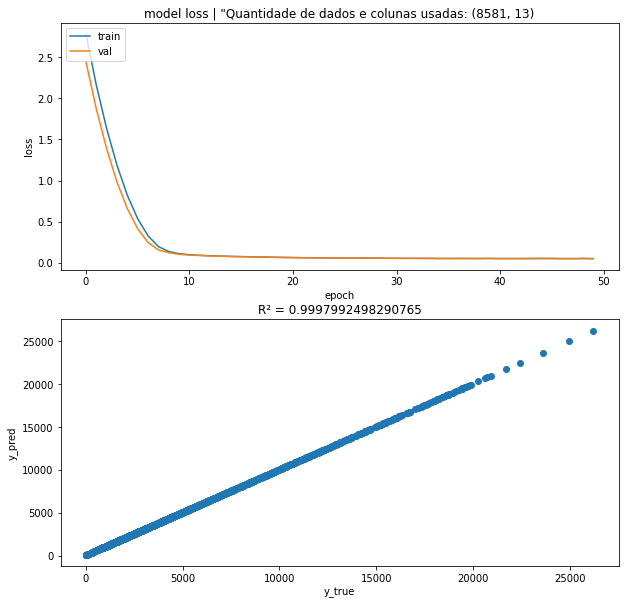

In [1393]:

df_valid_scaled = np.column_stack((x_valid, y_valid))
df_valid = scaler.inverse_transform(df_valid_scaled)
y_true = y_valid


y_pred = model.predict(x_valid)
pred_df = pd.concat([pd.DataFrame(x_valid).reset_index(drop=True), pd.DataFrame(y_pred)], axis=1)
pred_df = scaler.inverse_transform(pred_df)
pred_df = pd.DataFrame(pred_df)
pred_df.columns = df.columns
pred_df

r2 = r2_score(y_true, y_pred)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('model loss | "Quantidade de dados e colunas usadas: {}'.format(df.shape))
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')

axes[1].scatter(x=df_valid[:, -1], y=pred_df['total (R$)'])
# axes[0].plot(history.history['val_loss'])
axes[1].set_title('R² = {}'.format(r2))
axes[1].set_ylabel('y_pred')
axes[1].set_xlabel('y_true')

print("Quantidade de dados e colunas usadas: {}".format(df.shape))

plt.show()

# ----------------------------------------

# -----------------------------------------------------